# **Introduction**

In this project I want to explore how videogames can serve as a source for synthetic data in computer vision use cases. For a proof of concept, I chose the game Mario Kart Super Circuit. After I recorded images from the game, a Convolutional Neural Network will be trained to classify the images into three different classes which correspond to a steering-direction the driver should take, based on the street ahead:

1. Left
2. Right
3. Forward

# **Task 1 - The Data**

The data was collected by myself. To do so, I used the imageCollector.py script, which can also be found in this project. The script simply records an image once every 0.25 seconds and saves the file. The filename includes the direction according to which button was pressed at the time the image was taken. If no direction-key (right, left) was used, the direction is "forward". By recording the data this way, I was able to not only record the images, but at the same time also the labels belonging to the images. However, I must mention that this method can result in some mistakes, depending on how "correctly" I steered the kart in the game. I chose to use this method anyway, because it represented an efficient way to save time while the data collection phase.

## I. What exactly is the data?

The dataset consists of images taken from the videogame. Within Python and the following experiments, the images will be represented by Tensors, which are multi-dimensional arrays. While the exact size of the images does not matter at this point, I want to mention that each image is divided into three different "layers" - one for each RGB-channel. 

## II. Why this data?

The collected data is perfect for this project and the PoC of my proposed idea, because it is rather simple. The videogame itself is quite old and was originally released for very limited hardware, therefore the graphics are of a low-resolution and dont include many details. Furthermore, I recorded only the lower half of the games screen, as this is where the road can be found. I expect that these two points will not only make it more simple for a CNN to learn to classify the images correctly, but that the process will also be quite fast. 

# **Task 2 - Initial Data Analysis**

First of all, I want to present an example image. After that, we will take a look at the distribution of classes.

In [69]:
import pandas as pd
import os
from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision.io import read_image
from torch.utils.tensorboard import SummaryWriter
import copy
import time
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier

**REMARK: Load the model if available to skip training**

In [ ]:
model = torch.load("fine_tuned_resnet50.pth")

# move to gpu if available
if torch.cuda.is_available():
    model = model.to("cuda")

1094    2
Name: label, dtype: int64


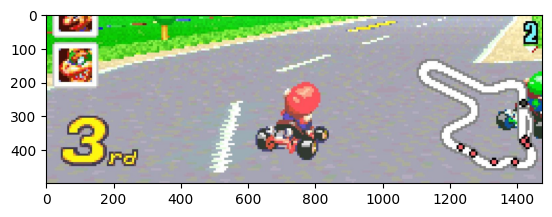

In [2]:
# show an image using PIL
img = cv.imread("data/train/20241109_174104_492494_right.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB) # convert colorspace to RGB
plt.imshow(img)
train_labels = pd.read_csv("train_labels.csv")
label = train_labels[train_labels["filename"] == "20241109_174104_492494_right.jpg"]["label"]
print(label)

The label belonging to the image is "2", which is the encription for "right". 

Next, we can inspect the size of the images.

In [3]:
print(f"The image is of shape {img.shape}")

The image is of shape (500, 1475, 3)


The images are 500 pixels high and 1475 pixels high. This unusual format originates from the limitations I described in the introduction where I used only the lower-half of the games screen. Furthermore we can see here the three RGB-layers, which I talked about in the previous task. Below I filter out each of the RGB-channels of the image. Brighter regions in the image represent a higher intensity of the channels color.

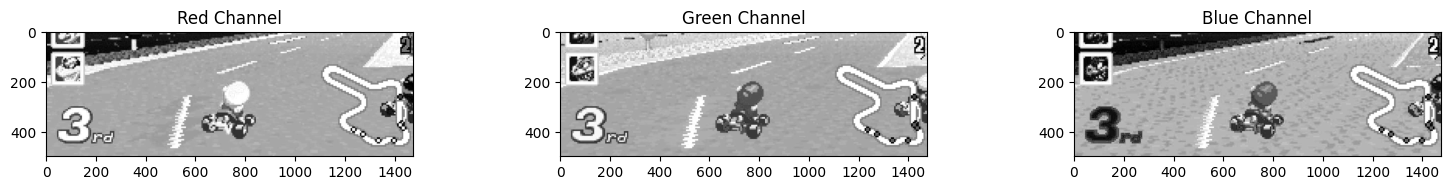

In [4]:
# Create a 1x3 subplot grid
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Display the red channel
axes[0].imshow(img[:, :, 0], cmap="gray")
axes[0].set_title('Red Channel')

# Display the green channel 
axes[1].imshow(img[:, :, 1], cmap="gray")  
axes[1].set_title('Green Channel')

# Display the blue channel
axes[2].imshow(img[:, :, 2], cmap="gray")
axes[2].set_title('Blue Channel')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.4)

plt.show()

# **Task 3 - Preprocessing**

The dataset has been properly collected before and therefore does not require further preprocessing at this point. Later on, for the experiments, the images will be transformed according to the expected inputs of the model. 

# **Task 4 - Exploratory Data Analysis**

As I havent made any changes to the dataset in the previous chapter, I will simply take a look at the distribution of the classes here.

**DISCLAIMER:** I deleted some images randomly before from the class "forward", because it had far more images than the other classes. This originated from the way the images were recorded directly while playing the videogame. Naturally, the race-tracks have longer straight parts than curves, resulting in more frames in which the driver doesnt need to steer.

In [5]:
left = 0
right = 0
forward = 0

for file in os.listdir("data/train"):
    
    direction = file.split("_")[3].split(".")[0]

    if direction == "left":
        left += 1
    elif direction == "right":
        right += 1
    elif direction == "forward":
        forward += 1

for file in os.listdir("data/test"):
    
    direction = file.split("_")[3].split(".")[0]

    if direction == "left":
        left += 1
    elif direction == "right":
        right += 1
    elif direction == "forward":
        forward += 1

print("Left: ", left)
print("Right: ", right)
print("Forward: ", forward)
print(f"Total: {left + right + forward}")

Left:  525
Right:  532
Forward:  524
Total: 1581


We can see that all classes have approximately the same amount of images, around 525-530. This sums up to a total size of the dataset of 1581 images. Keeping in mind that the images are rather simple, I expect this to be sufficient for the experiments using a pre-trained model in the Deep Learning Task.

# **Task 5 - Baselines**

## **I. Evaluation Metrics**
For the evaluation of the model, I will choose the following two metrics:

1. Test Accuracy - Offers a simple and quick evaluation how good the model performs. It is the percentage of overall correct predictions.

2. Precision - This metric measures class-wise the proportion of predicted positive instances that are actually correct. "Positive" means the model predicts the considered class, negative means it doesnt predict it (and therefore another). The formula is as follows:

True Positives / (True Positives + False Positives)

When measuring Precision for class X:
True Positive = Model correctly predicts class X for image Y 
False Negative = Model predicts class X for image Y, but image is from another class

By evaluating each class seperately, this metric will provide insight on how well the model predicts each individual class.

## **II. Heuristic Baseline**

As we have seen in the previous chapter, each class has roughly the same size and therefore the same probability of appearing and I assume the same distribution within the train set. That is why I choose to simply predict the class at random for this baseline. Furthermore, for the baselines I will reduce the images to one color channel and therefore reduce them to grayscale.

In [48]:
# Load all the images and labels
# train set
X_train = []
#read-in images
for img in os.listdir("data/train"):
    X_train.append(cv.imread(f"data/train/{img}", cv.IMREAD_GRAYSCALE))
# convert to numpy array
X_train = np.array(X_train)
# flatten 2D images to 1D
X_train = X_train.reshape(X_train.shape[0], -1)

# labels
Y_train = pd.read_csv("train_labels.csv")["label"]
Y_train = np.array(Y_train)

# test set
X_test = []
# images
for img in os.listdir("data/test"):
    X_test.append(cv.imread(f"data/test/{img}", cv.IMREAD_GRAYSCALE))
X_test = np.array(X_test)
# flatten 2D images to 1D
X_test = X_test.reshape(X_test.shape[0], -1)

# labels
Y_test = pd.read_csv("test_labels.csv")["label"]
Y_test = np.array(Y_test)

In [49]:
# dummy classifier predicting at random
dummy = DummyClassifier(strategy="uniform")

# fit the model
dummy.fit(X_train, Y_train)

DummyClassifier(strategy='uniform')

In [50]:
# test the model
acc_dummy = dummy.score(X_test, Y_test)*100
print(f"Accuracy: {score}")

Accuracy: 0.34069400630914826


In [97]:
y_pred = dummy.predict(X_test)

precision_dummy = precision_score(Y_test,y_pred, average=None)*100
precision_dummy = np.around(np.array(precision_dummy), 2)

In [98]:
def collectMetrics(df, model_name, metric_name, metric_value):
    # append the new metrics to the dataframe
    df = pd.concat([df, pd.DataFrame({
        "model": [model_name],
        "metric": [metric_name],
        "value": [metric_value],
    })], axis=0)

    return df

In [99]:
collected_metrics = pd.DataFrame(columns=["model", "metric", "value"])

collected_metrics = collectMetrics(collected_metrics, "dummy", "accuracy", acc_dummy)
collected_metrics = collectMetrics(collected_metrics, "dummy", "precision", precision_dummy)

collected_metrics.head()

/tmp/ipykernel_29/1522508662.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({


,model,metric,value
0,dummy,accuracy,35.33123
0,dummy,precision,"[29.41, 33.33, 31.45]"


The heuristic baseline - or random guesser - performs as expected. The accuracy of roughly 33% represents the class distribution.

## **III. Classical Machine Learning**

Before I begin with the Deep Learning models, I will evluate the performance of the classic ML algorithm K-NearestNeighbors Classifier for this use-case. It is important to consider also more simple solutions and not to always jump to Deep Learning for all problems, as DL algorithms are considerably more computationally intensive. Furthermore, we can investigate how big the improvement will be, if there is one at all.

In [100]:
# use default values for classifier
knn = KNeighborsClassifier()

# fit the model
knn.fit(X_train, Y_train)

# test the model
acc_knn = knn.score(X_test, Y_test)*100

y_pred = knn.predict(X_test)
precision_knn = precision_score(Y_test,y_pred, average=None)*100
precision_knn = np.around(np.array(precision_knn), 2)

collected_metrics = collectMetrics(collected_metrics, "knn", "accuracy", acc_knn)
collected_metrics = collectMetrics(collected_metrics, "knn", "precision", precision_knn)

collected_metrics.head()

,model,metric,value
0,dummy,accuracy,35.33123
0,dummy,precision,"[29.41, 33.33, 31.45]"
0,knn,accuracy,73.18612
0,knn,precision,"[70.54, 67.47, 80.95]"


The results show that the KNN-Classifier performs far better than the random-guesser. With an accuracy of 73% and 31%. the random guesser is not usable for this problem, while the knn-classifier could be considered.

# **Task 6 - Deep Learning Experiments**

In this chapter I will train, optimize and evaluate a convolutional neural network (CNN) to classify the images from the presented dataset. CNNs are a type of Neural Networks, which are especially suitable for image data. The name originates from the convolutional layers, which, in short, reduce the input to feature maps, while keeping important features. For the CNN, I will use the pre-trained ResNet50 architecture, which has already proven itself to perform very well in image classification. Training a new model from scratch would take much more time with uncertain results and transfer-learning is a very important concept in Deep Learning, which one should understand and be able to apply. 

## **I. Load ResNet50 model**

In [8]:
weights = models.ResNet50_Weights.DEFAULT
preprocess_transform = weights.transforms()
model = models.resnet50(weights=weights)

# Move model to gpu if available
if torch.cuda.is_available():
    model.cuda()

## **II. Load Dataset into DataLoaders**

In [9]:
# code is from torch documentation
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Ensure proper indexing by using .loc[idx] or .iloc[idx]
        # Assuming first column is image filename and second column is label
        img_name = self.img_labels.iloc[idx, 0]  # Get filename from first column
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        label = self.img_labels.iloc[idx, 1]  # Get label from second column

        if self.transform:
            image = self.transform(image)

        return image, label

In [10]:
train_dataset = CustomImageDataset(annotations_file="train_labels.csv", img_dir="data/train", transform=preprocess_transform)
test_dataset = CustomImageDataset(annotations_file="test_labels.csv", img_dir="data/test", transform=preprocess_transform)

# train dataset will be divided into validation and train
valid_dataset = CustomImageDataset(annotations_file="train_labels.csv", img_dir="data/train", transform=preprocess_transform)

In [11]:
# Following Code is from lecture notebook 06_01_lenet5
BATCH_SIZE = 128 # 1264 / 128 = 9.875 total batches
NUM_WORKERS = 0
VALIDATION_RATIO = 0.1
TRAIN_SIZE = 1264

num = int(VALIDATION_RATIO * TRAIN_SIZE)
train_indices = torch.arange(0, TRAIN_SIZE - num)
valid_indices = torch.arange(TRAIN_SIZE - num, TRAIN_SIZE)

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=False,
                          sampler=valid_sampler)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          # Drop the last (usually smaller) batch. 
                          # Since we shuffle the dataset every time we load it 
                          # (using the SubsetRandomSampler) -- and thus every epoch --
                          # we randomly exclude a small subset of the data in every epoch.
                          # Otherwise, the last batch would contain fewer items and thus 
                          # these items would have a disproportionally high impact 
                          # on weight update during training
                          drop_last=True,
                          sampler=train_sampler)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         num_workers=NUM_WORKERS,
                         shuffle=False)

## **III. Check Dataset**

Image batch dimensions: torch.Size([128, 3, 224, 224])
Image label dimensions: torch.Size([128])
Class labels of 10 examples: tensor([1, 2, 0, 2, 1, 1, 0, 1, 0, 2])
---------
tensor([1, 2, 0, 2, 1, 1, 0, 1, 0, 2])


<Figure size 640x480 with 0 Axes>

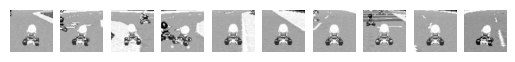

In [12]:
# Checking the dataset
torch.manual_seed(42) # set random seed as the train loader always loads a new permutation of the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    print('---------')
    print(labels[0:10])
    plt.figure()
    fig, axs = plt.subplots(1, 10) 
    for i in range(0,10):
        axs[i].imshow(images[i,0], cmap="gray")
        axs[i].set_axis_off()
    break

## **IV. Training**

To conduct the training, we first have to replace the final classification layer to match the new amount of labels. All other layers will be preserved, which is the core-element of transfer-learning. We are using the weights, which have been successfully trained before. Furthermore, we will include a Dropout-Layer right after the first Convolutional Layer.

In [13]:
def loadCustomModel(dropout_rate=0.5):
    weights = models.ResNet50_Weights.DEFAULT
    preprocess_transform = weights.transforms()
    model = models.resnet50(weights=weights)

    # Replace the final layer for the number of classes in your dataset
    num_classes = 3  # Change this to the number of classes in your dataset
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    # replace the first convolutional layer with a convolutional layer followed by a dropout layer
    model.conv1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
        nn.Dropout2d(dropout_rate)
    )

    # Move model to gpu if available
    if torch.cuda.is_available():
        model.cuda()

    return model

In [14]:
def get_targets_and_predictions(model, data_loader):
    '''
    create two lists: actual and predicted target 
    of a dataset in a data_loader
    enumerated in batches
    Assumption: model returns a tensor with dimensionality (batch, class probability)
    '''
    all_targets, all_predictions = [], []
    
    for i, (features, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            features, targets = features.to("cuda"), targets.to("cuda")
        
        # Predict probabilities for each instance in the current batch
        y_proba = model(features)
        _, predicted_labels = torch.max(y_proba, dim=1)
        
        # Append the batch predictions and targets to the lists
        all_targets.append(targets)
        all_predictions.append(predicted_labels)
    
    # Concatenate the list of tensors into a single tensor
    all_targets = torch.cat(all_targets)
    all_predictions = torch.cat(all_predictions)
    
    # Move tensors to CPU and convert to numpy arrays
    if torch.cuda.is_available():
        all_targets = all_targets.cpu()
        all_predictions = all_predictions.cpu()
        
    all_targets = all_targets.numpy()
    all_predictions = all_predictions.numpy()
    
    return all_targets, all_predictions

In [4]:
def train_model(model, num_epochs, 
                train_loader, valid_loader,
                optimizer, criterion, patience):

    writer = SummaryWriter()
    best_model_state=copy.deepcopy(model.state_dict())
    best_valid_acc=-float('inf')
    best_epoch=0

    start_time = time.time()

    if torch.cuda.is_available():
        model.to("cuda")

    counter = 0
    
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            # Check if gpu available
            if torch.cuda.is_available():
                # Move features and targets to the correct device
                features, targets = features.to("cuda"), targets.to("cuda")

            y_pred = model(features)

            loss = criterion(y_pred, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():  
            y, y_pred=get_targets_and_predictions(model=model, data_loader=train_loader)
            train_acc=accuracy_score(y, y_pred)*100

            y, y_pred=get_targets_and_predictions(model=model, data_loader=valid_loader)
            valid_acc=accuracy_score(y, y_pred)*100
                        
            print(f'Epoch: {epoch} | Train: {train_acc :.2f}% | Validation: {valid_acc :.2f}%')

            writer.add_scalars("resnet/acc", {'train': train_acc, 'val': valid_acc}, epoch)
            writer.flush()
            
            if (valid_acc>best_valid_acc):
                best_valid_acc=valid_acc
                best_epoch=epoch
                best_model_state=copy.deepcopy(model.state_dict())
            
            # Check for early-stoppping
            elif valid_acc < best_valid_acc:
                # increase counter of epochs since last improvement
                counter += 1
                if counter >= patience:
                    print(f'Early stopping at epoch {epoch} and returning current best model')
                    # break out of training loop and return model
                    break

        elapsed = (time.time() - start_time)/60
        print(f'Time elapsed: {elapsed:.2f} min')
        
    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')
    writer.close()
    print("Best Validation Epoch: ", best_epoch)
    model.load_state_dict(best_model_state)
    return model

## Hyperparameter Optimization

Before we begin the final training, we will first try to optimize the dropout probabiliyt of the included dropout layer. For this process, we will search through a predefined searchgrid of parameters by starting short trainings and compare them to eachother. The parameter belonging to the best performing training will be chosen as the final value.

In [39]:
torch.manual_seed(42)

criterion=torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# short training for optimization of dropout rate
NUM_EPOCHS = 10

# grid-search options
drop_probs = [0.1, 0.2, 0.3, 0.4, 0.5]
test_accs = {}

for p in drop_probs:
    
    # load model with custom dropout
    model = loadCustomModel(dropout_rate=p)

    criterion=torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

    # start training
    model = train_model(
        model=model,
        num_epochs=NUM_EPOCHS,
        train_loader=train_loader,
        valid_loader=valid_loader,
        optimizer=optimizer,
        criterion=criterion,
        patience=11) # train all epochs 
    
    # test model
    y, y_pred=get_targets_and_predictions(model=model, data_loader=test_loader)
    test_acc=accuracy_score(y, y_pred)
    # append score to dictionary
    test_accs[p] = test_acc

Epoch: 0 | Train: 54.39% | Validation: 56.35%
Time elapsed: 0.68 min
Epoch: 1 | Train: 66.41% | Validation: 67.46%
Time elapsed: 1.37 min
Epoch: 2 | Train: 74.12% | Validation: 79.37%
Time elapsed: 2.06 min
Epoch: 3 | Train: 69.73% | Validation: 66.67%
Time elapsed: 2.74 min
Epoch: 4 | Train: 77.25% | Validation: 77.78%
Time elapsed: 3.43 min
Epoch: 5 | Train: 82.23% | Validation: 80.95%
Time elapsed: 4.11 min
Epoch: 6 | Train: 83.59% | Validation: 78.57%
Time elapsed: 4.79 min
Epoch: 7 | Train: 84.77% | Validation: 83.33%
Time elapsed: 5.48 min
Epoch: 8 | Train: 76.66% | Validation: 61.90%
Time elapsed: 6.16 min
Epoch: 9 | Train: 86.62% | Validation: 82.54%
Time elapsed: 6.84 min
Total Training Time: 6.84 min
Best Validation Epoch:  7
Epoch: 0 | Train: 35.84% | Validation: 36.51%
Time elapsed: 0.68 min
Epoch: 1 | Train: 50.20% | Validation: 58.73%
Time elapsed: 1.37 min
Epoch: 2 | Train: 66.70% | Validation: 64.29%
Time elapsed: 2.06 min
Epoch: 3 | Train: 73.63% | Validation: 78.57%
T

In [40]:
test_accs

{0.1: 0.8012618296529969,
 0.2: 0.7665615141955836,
 0.3: 0.8201892744479495,
 0.4: 0.7886435331230284,
 0.5: 0.7760252365930599}

<Axes: >

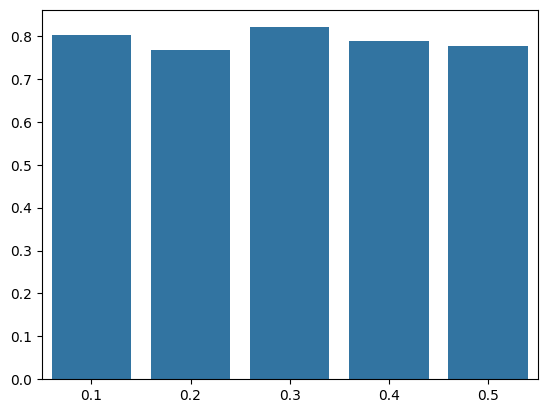

In [55]:
import seaborn as sns
sns.barplot(x=drop_probs, y=test_accs.values())

**Result**

Looking at the results, the best test accuracy was achieved with the dropout-probability = 0.3. However, all results were very similar.

## Final training

Next, we start the final training with the optimized parameter. We train for 100 Epochs, but with a patience of 20. This mechanism will stop the training early if there has been no improvement of the validation accuracy for the last 20 epochs. After stopping the training, the model and epoch achieving the best validation accuracy so far will be returned.

In [22]:
torch.manual_seed(42)

NUM_EPOCHS = 100

# load model with custom dropout
model = loadCustomModel(dropout_rate=0.3)

criterion=torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# start training
model = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    optimizer=optimizer,
    criterion=criterion,
    patience=20)

Epoch: 0 | Train: 48.34% | Validation: 49.21%
Time elapsed: 0.62 min
Epoch: 1 | Train: 57.81% | Validation: 59.52%
Time elapsed: 1.23 min
Epoch: 2 | Train: 72.46% | Validation: 72.22%
Time elapsed: 1.85 min
Epoch: 3 | Train: 75.29% | Validation: 78.57%
Time elapsed: 2.47 min
Epoch: 4 | Train: 77.83% | Validation: 80.16%
Time elapsed: 3.09 min
Epoch: 5 | Train: 79.30% | Validation: 82.54%
Time elapsed: 3.70 min
Epoch: 6 | Train: 80.76% | Validation: 80.95%
Time elapsed: 4.32 min
Epoch: 7 | Train: 83.11% | Validation: 84.13%
Time elapsed: 4.93 min
Epoch: 8 | Train: 78.52% | Validation: 69.05%
Time elapsed: 5.55 min
Epoch: 9 | Train: 85.16% | Validation: 86.51%
Time elapsed: 6.17 min
Epoch: 10 | Train: 85.06% | Validation: 82.54%
Time elapsed: 6.78 min
Epoch: 11 | Train: 85.55% | Validation: 85.71%
Time elapsed: 7.40 min
Epoch: 12 | Train: 85.25% | Validation: 80.95%
Time elapsed: 8.02 min
Epoch: 13 | Train: 86.62% | Validation: 83.33%
Time elapsed: 8.63 min
Epoch: 14 | Train: 86.43% | Va

In [91]:
y, y_pred=get_targets_and_predictions(model=model, data_loader=test_loader)
test_acc=accuracy_score(y, y_pred)*100
print(f'Test accuracy {test_acc :.2f}%')

Test accuracy 84.86%


**Tensorboard Visualization**

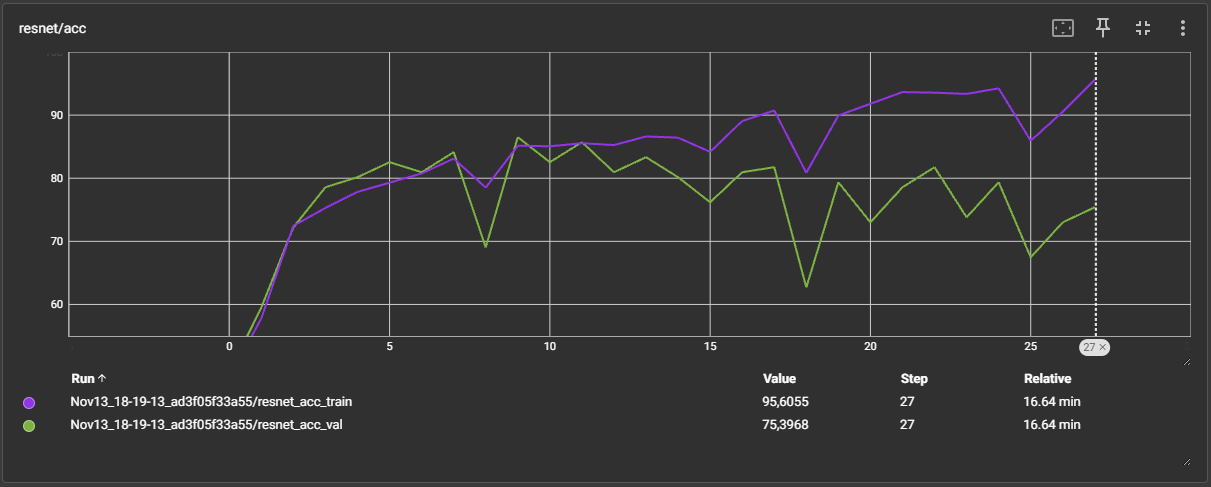

In [3]:
from IPython.display import Image
Image("tensorboard_training.png")

In this image we can see the progress of the training as shown in tensorboard. We can see very well how the validation accuracy (in green) does not increase after the ninth epoch, which then leads to the early stopping, while the training accuracy increases. To prevent overfitting, the deciding metric is the validation accuracy. Overfitting describes the scenario when the model performs very well on the train set, but is trained too long on it so it specialises on this set and performs bad on unseen data (the validation and test set).

In [ ]:
test_precision = precision_score(y,y_pred, average=None)*100
test_precision = np.around(np.array(test_precision), 2)

**Comparison of Baselines and CNN**

In [101]:
collected_metrics = collectMetrics(collected_metrics, "ResNet50", "accuracy", test_acc)
collected_metrics = collectMetrics(collected_metrics, "ResNet50", "precision", test_precision)
collected_metrics.head(6)

,model,metric,value
0,dummy,accuracy,35.33123
0,dummy,precision,"[29.41, 33.33, 31.45]"
0,knn,accuracy,73.18612
0,knn,precision,"[70.54, 67.47, 80.95]"
0,ResNet50,accuracy,84.858044
0,ResNet50,precision,"[86.92, 84.27, 83.47]"


**Confusion-Matrix**

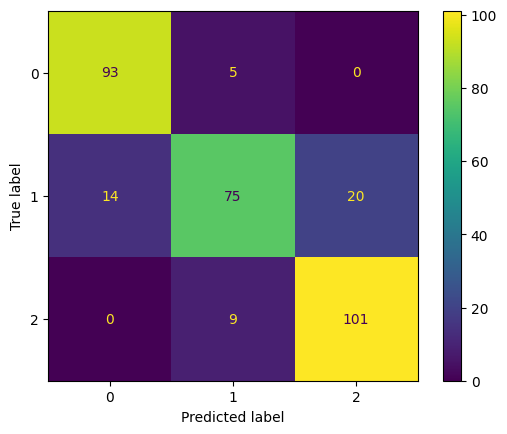

In [24]:
y, y_pred=get_targets_and_predictions(model=model, data_loader=test_loader)
ConfusionMatrixDisplay.from_predictions(y, y_pred)

# **Task 7 - Conclusions and Future Work**

**Summarize and interpret the achieved results.** 

First of all, we can see in the comparison of baselines and CNN that the CNN performs clearly better than the baselines. While the classic ML KNN-Classifier performs better than the random guesser, the CNN offers a strong improvement and the overall best performance.

The precision values are presented class-wise, so the first value is for class 0, second for class 1 and so on. It is interesting to see here that for each "model", the best-performing class is a different one (random -> class 1, knn -> class 2, cnn -> class 0). However, except for the knn-classifier, the precision values are quite close to eachother, so there is no class a model performs better or worse at in comparison to the other classes.

In the Confusion-Matrix of the ResNet50 we can see that classes 0 and 2 are never mixed up. Those are the classes "left" and "right". This leads to the conclusion that the model can clearly distinct between the two directions. However, for both directions, some missclassifications as "straight" (class 1) are made. This might originate again from how the data was recorded and mistakes the user/driver made. Another possibility is that some curves are very mild and therefore missclassified as "straight".

In conclusion we can say that the ResNet50 performs very well. The accuracy of 84,5% is very satisfying and the class-wise precision are  in the same area with 86.92, 84.27 and 83.47. However, it shouldnt be ignored that also the knn-classifier achieved a well performance of accuracy, while the precision varies more strongly and reaches only an okay value for the class 2.

**Recommend a course of action for the organization in your story based on the results of Task 6.**

After completing these experiments, I recommend going further ahead with this idea. If we upscale the approach, using higher resolution data and especially data from games using more realistic data, we can offer a very fast and simple way of collecting synthetic data for different use-cases. To further improve the results, I recommend tackling the limitations and proposed ideas in the following two paragraphs.

**Reflect on limitations and possible pitfalls of using these results. **

The resulting model doesnt need to necessarily be the best possible outcome, because no further hyperparameter optimization was performed. Furthermore, keeping in my mind that the data was rather simple, we cannot be sure to a hundred percent that this approach will achieve the same results when using highly-realistic data, as it becomes far more complex.

**Propose three ideas for future work (a short sketch or enumeration of ideas is sufficient, no further experiments). The ideas should not be too general (e.g., “try further algorithms”) but be specific to the project (e.g., “try Algorithm X, as because of Property Y, it might work specifically well on this dataset”).**

- Try smaller pre-trained networks, for example different versions of the ResNet-architecture, which can perform faster inference, which is important in real-time applications like autonomous driving
- While the old Mario Kart game was a good choice to proof the general idea is working, the graphics are far from realistic. Racing games or simulations like GTA5 can provide a more realistic look with even a some-what working traffic system
- Diversify the dataset to include more different scenarios to achieve a more generally-applicable model.

**Critically discuss the employed methodology (your choices as well as the choices given in these tasks). What could or even should have been done differently?**

As mentioned in the limitations of the results, no hyperparameter optimization was performed. While this process can take a lot of time, it is worth the wait and should be done in an ideal scenario. Furthermore, I did not test different models, which might perform better (or worse) or achieve similar scores while using a smaller architecture.

Additionally, the process of recording the test data could be improved. I am certain that there are some wrong labels within the dataset due to "bad driving/playing", which of course leads to worse results, at least when applied to new real data.

**Critically reflect the original task you pitched. In hindsight, were the goals realistic? What could have been changed at the time of the pitch?**

In general, the goals were realistic. I chose a game as basis for my dataset with very minimalistic design and low resolution, therefore it was rather "simple" for the model to identify simple forms like lines, corners and curves. For the pitch I mentioned training two different CNN models and comparing them, which wasnt part of the task and therefore not part of these experiments. This should have been changed and not stated in the pitch.